In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [2]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layer):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size,bias=False)
        for k in range(num_hidden_layer-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size,bias=False))
        self.output_layer = nn.Linear(hidden_size, output_size,bias=False)
        
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x

def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [3]:
INPUT_SIZE = 784
OUTPUT_SIZE=10
NUM_HID_LAYERS=1
NUM_EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.01
MOMENTUM=0.9

In [4]:
# Import the MNIST dataset as two separate datasets

train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

validation_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Create the data loader for training
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create the data loader for validating

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=1, shuffle=False) 

In [5]:
def network_layer_weight_extraction(model):
    network_weights=[]
    for para in model.named_parameters():
        if 'weight' in para[0]:
            network_weights.append(para[1].detach().numpy())
    return network_weights

In [6]:
def generalization_bound(no_hidden_units, num_epochs):

    model=NeuralNet(INPUT_SIZE,no_hidden_units,OUTPUT_SIZE,NUM_HID_LAYERS)
    ReLU_glorot_init(model)

    network_weights=network_layer_weight_extraction(model)
    U_0=network_weights[0].copy()
    V_0=network_weights[1].copy()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM) 

    def train_epoch():
        for images, labels in train_dataset_loader:  
            images = images.reshape(-1, 28*28)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        return loss.item()

    for epoch in range(num_epochs):
        loss=train_epoch()
        print ('Epoch {} (hidden units: {}), Loss: {:.3f}'.format(epoch+1,no_hidden_units,loss))
        if loss<0.01 and epoch>=15:
            break

    with torch.no_grad():
        total_train=0
        correct_train=0
        for images, labels in train_dataset_loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

    with torch.no_grad():
        total_val=0
        correct_val=0
        for images, labels in validation_dataset_loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
        

    network_weights=network_layer_weight_extraction(model)
    U=network_weights[0]
    V=network_weights[1]

    return (norm(U_0,ord=2)+norm(U-U_0))*norm(V), norm(U,ord=2), norm(U), norm(U_0-U), norm(V,ord=2), norm(V), norm(V_0-V), (total_train-correct_train)/total_train, (total_val-correct_val)/total_val

In [7]:
measure=[]
U_norms=[]
V_norms=[]
trainErrorList=[]
valErrorList=[]

for n in range(6):
    m,u_1,u_2,u_3,v_1,v_2,v_3, trainerror, valerror=generalization_bound(2**(6+n),NUM_EPOCHS)
    measure.append(m)
    U_norms.append([u_1,u_2,u_3])
    V_norms.append([v_1,v_2,v_3])
    trainErrorList.append(trainerror)
    valErrorList.append(valerror)

Epoch 1 (hidden units: 64), Loss: 0.445
Epoch 2 (hidden units: 64), Loss: 0.141
Epoch 3 (hidden units: 64), Loss: 0.087
Epoch 4 (hidden units: 64), Loss: 0.054
Epoch 5 (hidden units: 64), Loss: 0.041
Epoch 6 (hidden units: 64), Loss: 0.087
Epoch 7 (hidden units: 64), Loss: 0.018
Epoch 8 (hidden units: 64), Loss: 0.056
Epoch 9 (hidden units: 64), Loss: 0.009
Epoch 10 (hidden units: 64), Loss: 0.047
Epoch 11 (hidden units: 64), Loss: 0.026
Epoch 12 (hidden units: 64), Loss: 0.064
Epoch 13 (hidden units: 64), Loss: 0.034
Epoch 14 (hidden units: 64), Loss: 0.064
Epoch 15 (hidden units: 64), Loss: 0.016
Epoch 16 (hidden units: 64), Loss: 0.013
Epoch 17 (hidden units: 64), Loss: 0.003
Epoch 1 (hidden units: 128), Loss: 0.146
Epoch 2 (hidden units: 128), Loss: 0.092
Epoch 3 (hidden units: 128), Loss: 0.265
Epoch 4 (hidden units: 128), Loss: 0.078
Epoch 5 (hidden units: 128), Loss: 0.032
Epoch 6 (hidden units: 128), Loss: 0.124
Epoch 7 (hidden units: 128), Loss: 0.071
Epoch 8 (hidden units: 12

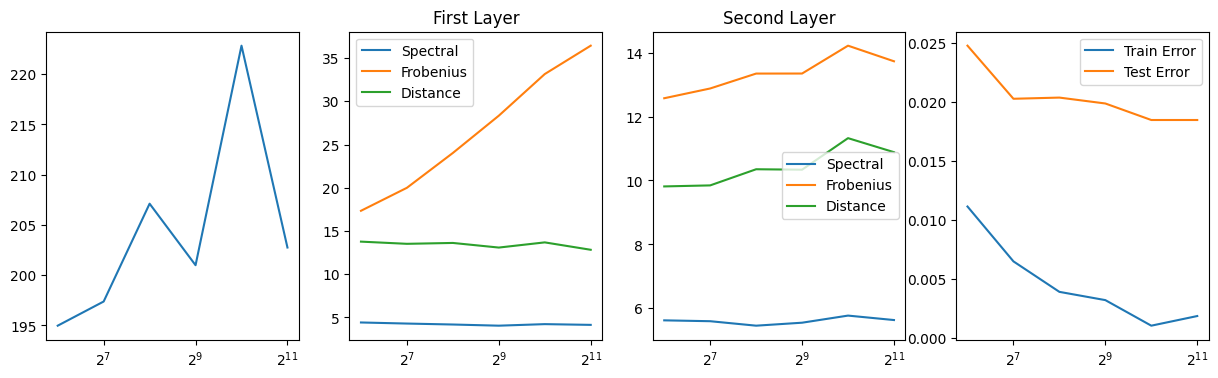

In [8]:
fig, axs = plt.subplots(1,4, figsize=(15,4))

x=[2**(6+n) for n in range(6)]

axs[0].plot(x,measure)

axs[1].plot(x,[norms[0] for norms in U_norms],label='Spectral')
axs[1].plot(x,[norms[1] for norms in U_norms],label='Frobenius')
axs[1].plot(x,[norms[2] for norms in U_norms],label='Distance')
axs[1].set_title('First Layer')
axs[1].legend()

axs[2].plot(x,[norms[0] for norms in V_norms],label='Spectral')
axs[2].plot(x,[norms[1] for norms in V_norms],label='Frobenius')
axs[2].plot(x,[norms[2] for norms in V_norms],label='Distance')
axs[2].set_title('Second Layer')
axs[2].legend()

axs[3].plot(x,trainErrorList,label='Train Error')
axs[3].plot(x,valErrorList,label='Test Error')
axs[3].legend()

axs[0].set_xscale('log',base=2)
axs[1].set_xscale('log',base=2)
axs[2].set_xscale('log',base=2)
axs[3].set_xscale('log',base=2)

In [ ]:
norms1=[]
norms2=[]
for k in range(len(U_norms)):
    norms1.append(V_norms[k][1]*)

In [ ]:
plt.plot(x,)